# Tech - API REST pour deep learning avec FastAPI

Certains sites web actuels font appels à de nombreux modèles de machine learning. Un moteur de recherche affiche beaucoup de résultats différents, des suggestions, des résultats de recherches, des recherches associées, des informations, des résultats locaux. Chacun d'entre eux fait appel à un ou plusieurs modèles de machine learning plus ou moins complexes. Le modèle classique d'un site web, ce sont deux machines :
* le **client** : la machine de celui qui consiste le site web
* le **server** : la machine qui retourne la page pour celui qui consiste le site web

De plus en plus, les pages sont dynamiques : deux internautes ne verront pas la même chose même s'ils vont au même url, ne serait-ce que pour les publicités affichées qui semblent parfois influencées par l'historique de navigation. Les pages sont calculées. Parfois, les calculs sont si complexes qu'une seule machine ne peut pas les faire seule. Le server fait appel à d'autres serveurs à qui on envoie des données pour qu'ils retournent une prédiction. Le mécanisme le plus souvent utilisé est celui-ci d'une [API REST](https://fr.wikipedia.org/wiki/Representational_state_transfer). C'est ce mécanisme qu'on va voir ici. Un avantage de ce système est que la machine qui fait des calculs peut planter sans que la machine qui produit les pages ne s'arrête. Les API REST échangent des informations le plus souvent au format [JSON](https://docs.python.org/3/library/json.html).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Enoncé


### Q1 : un modèle de deep learning, une image

Il faut arriver à faire marcher le code suivant.

In [3]:
import os

url = "https://github.com/onnx/models/raw/master/vision/classification/mobilenet/model/mobilenetv2-7.onnx"
name = url.split('/')[-1]
if not os.path.exists(name):
    print("download %r" % name)
    import urllib.request as ur
    ur.urlretrieve(url, name)

In [4]:
url = "https://upload.wikimedia.org/wikipedia/commons/c/c6/Okonjima_Lioness.jpg"
img_name = url.split('/')[-1]
if not os.path.exists(img_name):
    print("download %r" % img_name)
    import urllib.request as ur
    ur.urlretrieve(url, img_name)

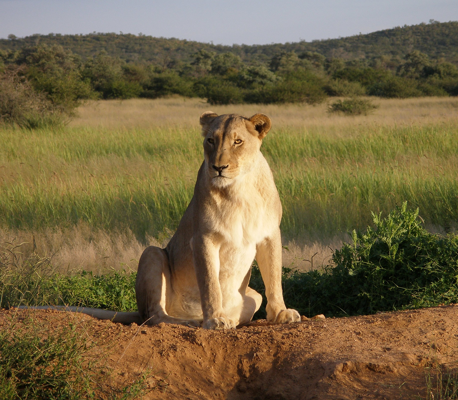

In [5]:
from PIL import Image
im = Image.open(img_name)
width, height = im.width // 4, im.height // 4
im.resize((width, height))

In [6]:
#! pip install onnxruntime
from onnxruntime import InferenceSession
sess = InferenceSession(name)

Le modèle n'accepte les images que d'une taille spéficique puis il faut la convertir en [numpy.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html).

In [7]:
sess.get_inputs()[0].name, sess.get_inputs()[0].shape, sess.get_inputs()[0].type

('data', [1, 3, 224, 224], 'tensor(float)')

In [8]:
import numpy
im224 = numpy.asarray(im.resize((224, 224)))
im224.shape

(224, 224, 3)

Il faut transposer, ajouter une dimension et convertir en float.

In [9]:
img = (im224.transpose((2, 0, 1))[numpy.newaxis, :, :, :] / 255).astype(numpy.float32)
img.shape, img.dtype

((1, 3, 224, 224), dtype('float32'))

On applique le modèle de deep learning, il retourne des probabilités pour chacune des mille classes sur lesquelles il a été appris.

In [10]:
res = sess.run(None, {'data': img})
res[0][0, :5]

array([-0.24502414, -1.7939606 ,  2.0713477 ,  0.05494323,  4.236496  ],
      dtype=float32)

Comme ce n'est pas lisible, on pourra copier le ficher [imagenet_classes.py](https://github.com/sdpython/ensae_teaching_cs/blob/master/src/ensae_teaching_cs/data/imagenet_classes.py) pour avoir la signification de chaque classe.

In [11]:
from ensae_teaching_cs.data import interpret_imagenet_results
cls = interpret_imagenet_results(res[0][0])
cls

OrderedDict([('lion, king of beasts, Panthera leo', 17.189928),
             ('white wolf, Arctic wolf, Canis lupus tundrarum', 13.258874),
             ('Arctic fox, white fox, Alopex lagopus', 12.038377),
             ('kuvasz', 11.635131),
             ('dingo, warrigal, warragal, Canis dingo', 11.077603),
             ('Samoyed, Samoyede', 11.07625),
             ('baboon', 10.812914),
             ('timber wolf, grey wolf, gray wolf, Canis lupus', 10.627019),
             ('Labrador retriever', 10.469205),
             ('golden retriever', 9.689025)])

Ca ne marche pas trop mal.

### Q2 : image et json

Les données sont échangées dans un format binaire ou texte sur internet. Il faut pouvoir tout convertir en texte. C'est étape est appelée [sérialisation](https://fr.wikipedia.org/wiki/S%C3%A9rialisation). C'est ce qu'on fait pour une image

In [12]:
import base64
from io import BytesIO

def image_to_str(im):
    buffered = BytesIO()
    im.save(buffered, format="JPEG")
    img_bytes = base64.b64encode(buffered.getvalue())
    img_str = img_bytes.decode('utf-8')
    return img_str

img_str = image_to_str(im)
type(img_str), len(img_str)

(str, 619560)

Au format JSON, cela donne quelque chose comme cela :

In [13]:
import json
data = {'image': img_str}
data_json = json.dumps(data)
type(data_json), len(data_json)

(str, 619573)

Il faut écrire une fonction qui fait la manipulation inverse.

In [14]:
def str_to_img_to_array(img_str):
    pass

### Q3 : FastAPI

On s'inspire de l'exemple suivant : [FastAPI](https://fastapi.tiangolo.com/#example) qu'on adapte pour donner l'exemple qui suit qu'il faut compléter pour retourner les résultats de classification.

In [16]:
#!pip install fastapi

In [17]:
%%writefile apiapp.py
# coding: utf-8
import os
import json
import base64
from io import BytesIO
import urllib.request as ur
from imagenet_classes import interpret_imagenet_results
import numpy
from PIL import Image
from typing import Optional
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from onnxruntime import InferenceSession

app = FastAPI()


@app.get("/")
def read_root():
    return {"Hello": "World"}


def load_model():
    url = ("https://github.com/onnx/models/raw/master/vision/classification/"
           "mobilenet/model/mobilenetv2-7.onnx")
    name = url.split('/')[-1]
    if not os.path.exists(name):
        ur.urlretrieve(url, name)
    return InferenceSession(name)


sess = load_model()


def image_to_classification(data_json, sess):
    # on convertit le json en image
    # ...
    # on convertit l'image en array et on donne les dimensions attendues (224, 224)
    # ...
    # on prédit
    # ...
    # on retourne les 10 premières classes
    # return ...


# Defining a custom object using Pydantic
class Item(BaseModel):
    item_id: str
    image: str


@app.post("/imgpred/{model}/")
def read_item(model: str, item: Item):
    if model == 'mobilenetv2':
        data_json = item.image
        try:
            cls = image_to_classification(data_json, sess)
        except Exception as e:
            raise HTTPException(
                status_code=500, detail="Cannot predict due to %r" % e)
        return {"item_id": item.item_id,
                "results": [(name, float(p)) for name, p in cls.items()]}
    raise HTTPException(status_code=404, detail="Unexpected model %r." % model)

Overwriting apiapp.py


Ensuite, il faut exécuter la ligne de commande.

In [18]:
# !python -m uvicorn apiapp:app

Puis ouvrir l'url : ``http://127.0.0.1:8000``. Normalement, cela affiche ``{"Hello":"World"}``.

Puis l'url ``http://127.0.0.1:8000/docs``. C'est cette page de documentation que génère automatiquement *FastAPI* et c'est très pratique pour tester l'API depuis un navigateur.

### Q4 : il faut tester l'application depuis Python maintenant

Avec le module [requests](https://requests.readthedocs.io/en/master/) et faire une requête de type POST.

In [19]:
# !pip install requests

### Q5 : que manque-t-il pour faire une vraie API ?

## Réponses

### Q1

Un peu de persévérance n'a jamais fait de mal.

### Q2 : json

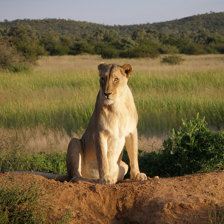

In [21]:
def str_to_img_to_array(img_str):
    # str -> bytes
    img_bytes = img_str.encode('utf-8')
    # des bytes restreint aux bytes libérés
    enc = base64.b64decode(img_bytes)
    # des bytes libérés à l'image
    buf = BytesIO(enc)
    return Image.open(buf)

str_to_img_to_array(img_str).resize((224,224))

Même fonction qui retourne les résultats de classification.

In [22]:
def image_to_classification(img_str, sess):
    # on convertit le json en image
    im = str_to_img_to_array(img_str)
    # on convertit l'image en array et on donne les dimensions attendues
    img = numpy.asarray(im.resize((224, 224)))
    im224 = numpy.asarray(im.resize((224, 224)))
    img = (im224.transpose((2, 0, 1))[numpy.newaxis, :, :, :] / 255).astype(numpy.float32)
    # on prédit
    res = sess.run(None, {'data': img})
    # on retourne les 10 premières classes
    return interpret_imagenet_results(res[0][0])

image_to_classification(img_str, sess)

OrderedDict([('lion, king of beasts, Panthera leo', 17.197624),
             ('white wolf, Arctic wolf, Canis lupus tundrarum', 13.242195),
             ('Arctic fox, white fox, Alopex lagopus', 11.990342),
             ('kuvasz', 11.614188),
             ('dingo, warrigal, warragal, Canis dingo', 11.113769),
             ('Samoyed, Samoyede', 11.025541),
             ('baboon', 10.8266325),
             ('timber wolf, grey wolf, gray wolf, Canis lupus', 10.669683),
             ('Labrador retriever', 10.519667),
             ('golden retriever', 9.731443)])

### Q3 : fichier modifié

In [23]:
%%writefile apiapp.py
# coding: utf-8
import os
import json
import base64
from io import BytesIO
import urllib.request as ur
from imagenet_classes import interpret_imagenet_results
import numpy
from PIL import Image
from typing import Optional
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from onnxruntime import InferenceSession


def load_model():
    url = ("https://github.com/onnx/models/raw/master/vision/classification/"
           "mobilenet/model/mobilenetv2-7.onnx")
    name = url.split('/')[-1]
    if not os.path.exists(name):
        ur.urlretrieve(url, name)
    return InferenceSession(name)


def str_to_img_to_array(img):
    # str -> bytes
    img_bytes = img.encode('utf-8')
    # des bytes restreint aux bytes libérés
    enc = base64.b64decode(img_bytes)
    # des bytes libérés à l'image
    buf = BytesIO(enc)
    return Image.open(buf)


def image_to_classification(img_str, sess):
    # on convertit le json en image
    im = str_to_img_to_array(img_str)
    # on convertit l'image en array et on donne les dimensions attendues
    img = numpy.asarray(im.resize((224, 224)))
    im224 = numpy.asarray(im.resize((224, 224)))
    img = (im224.transpose((2, 0, 1))[numpy.newaxis, :, :, :] / 255).astype(numpy.float32)
    # on prédit
    res = sess.run(None, {'data': img})
    # on retourne les 10 premières classes
    return interpret_imagenet_results(res[0][0])


sess = load_model()
app = FastAPI()


@app.get("/")
def read_root():
    return {"Hello": "World"}


# Defining a custom object using Pydantic
class Item(BaseModel):
    item_id: str
    image: str


@app.post("/imgpred/{model}/")
def read_item(model: str, item: Item):
    if model == 'mobilenetv2':
        img_str = item.image
        try:
            cls = image_to_classification(img_str, sess)
        except Exception as e:
            raise HTTPException(
                status_code=500, detail="Cannot predict due to %r" % e)
        return {"item_id": item.item_id,
                "results": [(name, float(p)) for name, p in cls.items()]}
    raise HTTPException(status_code=404, detail="Unexpected model %r." % model)

Overwriting apiapp.py


Ensuite il faut exécuter la ligne de commande : ``python -m uvicorn apiapp:app``.
        
Puis aller à l'adresse suivante : ``http://127.0.0.1:8000/``.

Le message ``{"Hello": "World"}`` doit apparaître sur l'écran.

Ensuite, il faut aller à l'adresse : ``http://127.0.0.1:8000/docs`` qui crée automatiquement une documentation générée pour ce site web en local.

### Q4 : utiliser l'API REST

Python propose des outils pour utiliser l'API REST.

In [24]:
import requests
class ReqError:
    def __init__(self, e):
        self.e = e
    @property
    def text(self):
        return str(self.e)
    def json(self):
        return str(self.e)
try:
    r = requests.get('http://127.0.0.1:8000/')
except Exception as e:
    r = ReqError(e)
print(r, r.text)

<Response [200]> {"Hello":"World"}


In [25]:
from IPython.display import HTML
try:
    r = requests.get('http://127.0.0.1:8000/docs')
except Exception as e:
    r = ReqError(e)
print(r, r.text)

<Response [200]> 
    <!DOCTYPE html>
    <html>
    <head>
    <link type="text/css" rel="stylesheet" href="https://cdn.jsdelivr.net/npm/swagger-ui-dist@3/swagger-ui.css">
    <link rel="shortcut icon" href="https://fastapi.tiangolo.com/img/favicon.png">
    <title>FastAPI - Swagger UI</title>
    </head>
    <body>
    <div id="swagger-ui">
    </div>
    <script src="https://cdn.jsdelivr.net/npm/swagger-ui-dist@3/swagger-ui-bundle.js"></script>
    <!-- `SwaggerUIBundle` is now available on the page -->
    <script>
    const ui = SwaggerUIBundle({
        url: '/openapi.json',
    oauth2RedirectUrl: window.location.origin + '/docs/oauth2-redirect',
        dom_id: '#swagger-ui',
        presets: [
        SwaggerUIBundle.presets.apis,
        SwaggerUIBundle.SwaggerUIStandalonePreset
        ],
        layout: "BaseLayout",
        deepLinking: true,
        showExtensions: true,
        showCommonExtensions: true
    })
    </script>
    </body>
    </html>
    


In [26]:
import pycurl_requests as req

def query_data(img_id, img):
    width, height = img.width // 8, img.height // 8
    img = img.resize((width, height))
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    img_bytes = base64.b64encode(buffered.getvalue())
    img_str = img_bytes.decode('utf-8')
    return {'item_id': img_id, 'image': img_str}


def query(img_id, img):
    data = query_data(img_id, img)
    try:
        return requests.post('http://127.0.0.1:8000/imgpred/mobilenetv2/',
                             data=json.dumps(data))
    except Exception as e:
        return ReqError(e)


res = query(img_name, Image.open(img_name))
res.json()

{'item_id': 'Okonjima_Lioness.jpg',
 'results': [['lion, king of beasts, Panthera leo', 16.449743270874023],
  ['white wolf, Arctic wolf, Canis lupus tundrarum', 12.503802299499512],
  ['Arctic fox, white fox, Alopex lagopus', 11.861382484436035],
  ['kuvasz', 11.585062026977539],
  ['dingo, warrigal, warragal, Canis dingo', 10.82335090637207],
  ['Samoyed, Samoyede', 10.261394500732422],
  ['baboon', 10.105708122253418],
  ['Arabian camel, dromedary, Camelus dromedarius', 9.99837875366211],
  ['timber wolf, grey wolf, gray wolf, Canis lupus', 9.871463775634766],
  ['tusker', 9.716681480407715]]}

In [27]:
# !curl -X POST "http://127.0.0.1:8000/imgpred/mobilenetv2/" -H  "accept: application/json" -H  "Content-Type: application/json" -d "{\"item_id\":\"Okonjima_Lioness.jpg\",\"image\":\"/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABQAFsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDoWu7OJWMl1CoU4OXAwaF1XTDn/T7bj/poK8fnaVJFI2Lg54zzVyJy6ZdR09MEH/CoeJsV7M9V/trSlbadQt8/74qxFqWnzECO9t2J6ASCvIYZ4JXKhgCe+aWOWIIWDn5T8wIo+sC5D2dHjf7jq30OafivFvtcqcI7q38JDcYqwniG9hkMRvrlVA+95hCn6Zp/WELkPYaCQK8ek1nUZY2EOo3EjKRlDKenr71E93PcMB9qkfIwQ7k5OfrQ8RFByHr017awAma5hjA/vOBWTc+LdFt2K/bRKw7RKW/XpXln2mCMeXKpDhucmlEsbRsVGcHPy8cUOuHId/P4709DiO3uH/3sLVc+PrbPFjJj/roP8K4BriNmVJFYMehUZ49/SpgluRnKfjnNS6zW4+UtRFL5CjgL2JxyaLfS7ncUSRtrHgnnFdG2nWM3Dw4wexI5q1HFDaHdEpGa8t1+yOi3cw5fB0ksiyC+MTj721OD+tLN4J86NQ2oN/tYQc/rXQC+4+6xH0phvQuDsc9uKPbSHaHYxh4ORYPLW7l2454BH/1qx49BleVkS/sJYCcLl8n9K7YXe5PuMAR371zfhOHdf3Ewt0ZraVhHHj75JwM/T+tXCq2m30GoRk0kUovDGpBvLhu7LHXCE5x+VXF8LX20Bp4z/n6V2Gu6Qmj3cGopHMGuEKkEnYh68e/P6VROpEKduSR15qHXb3CUIRdjmW0qW2cw+VdTDOA7KCPw4/nUsfhASbZRc3EPOdhUcVvPqhPGH9etI16zEoGZT6mj2zQrQMg+Foy2TPKTjsAKpP4Qy5K3V4B2Ada3zcz4ySSB1xTftJPIDY7cU1XktgtHsPDhlJLDjrUqtH1aT8K5x4r5ZMHJUd/WpRBdvt5xu6c1Hs33Dml2N4vEFA8zA61GlzCCPnGawporjB25YA4yPWqTGeOXYVbdgMPbFUqTa3E5tdDpL/UorbTrmVDlljO3HY9qm+HcdvDfxPdCffdHMWQdh2nk5z1rh9TmlDfZmJx1Iz29K9d8CWUN1DbKRtKIC8LDBB/vfiAKtw5Kdu5dJ3d2dV4lthdaNcQ7N2xPNTPqvP8AKvKzex8gRgE/rXs1yiLpcrNgnYxVSeW46V85y3UrSFgCOc4HaoVJyJqSSOha8iX+Ac+vbFIupQFssnbP4YrnjcSvlwpOASfpT0IdcNuV0XDk/dBzx+lDpW3Muc331W22jB4IyKrHVbbJ5/UVz90wuCHtmG/JLc9T6j2qsthdTKJDH96rjRTV2xe0l0OmkmJKKSckj5QavWs8Kjc65bORk9K5qO0vH2+YVWTOQpbnAq0LW+JUoqso5ALdabXmb3n2N6S/ticLtRT1yMHI6GsnW78C5t4bMhGClmdevPasy7llSQiWIxzA5zuHQevtVCe7hbXofKfdGV+bHOMHmrpxfNqifaNuzRH5F00ly84bzFZgxbr+Ne++E3ivdK0O4QAS/ZgH2jk44rze7trfUNSujbSptuJnZSehB6V3vw7mWPw3FG7lTGrIcfeHuKipPmSbN1Hl2CfxBbap4xntbd8x2DCI4PBO05I/HI/CvPJNV0VSGJjQ9NrjnFaWm3+h2fi63ktv3UrxsL3DEoQCAjezHLZ/CvNNb8P6ppepeUYmkWZiYGhO8OM4HTofY1VKCcnd2M6kpKKsrmrqOtQ/b5BbSqlssZ+UYHb9awJNRIkkldt4lUrtBxgfSqRs7wvhrWYsGwV2HrVuLSdRnK+XZyAHswx/Ounlit2cjUpPYS1lVgVMwGB8o9fatCKa58tdksgX02g1dsvDV08IYwhXXgkEY/DvWkPDdyVGIYVGOhb/AOtWU6kblqhN9ATVg0ir5YDepPSrUN8JJAFwTn7qnPNczK3kTrtIOVJbjjuAKu2F/wCYyg7FUL8oHSsZQ0ujeNR9WdOYjLkHlWHKHn9Ka2l2CR/Lawl15CqoBz1+tVI7/wAqVSxLJjO0c81chuGkjeRYycL8pAAOfc1i+ZHXGUXuNntTdsskcaBFILIygbxx0PapGup7CKSOzkMUcmVdVJHy4GR6jg1XmuDIEG7bKq4Bx6etUdQvWS0cyIVfaynafvE96a5nZFPlWoiNBGjyRxoYo35H+FW4LqBxt3LtB5ZuwrkG1SWXfHJLtDkFh0pyylgqB8geldKovqzD2y6Hof2iJyqI4yw+9waidEDAKQACTkL9yudtpQtmV3lSDkv7HsfypY79oXYrI5GSdjtkc1k6bvZGntFbU6bIzs2hlIG0K3Y98VZ88LgbhwMcrmuLfUJZGJBxjkDOMfSoBql2QC0/PfPWl7BsTrxR/9k=\"}"

### Q5 : faire une vraie API ?

Ce que les API ont en plus, c'est :
* Une API qui requiert de s'authentifier pour pouvoir l'utiliser. L'idée est de savoir qui s'en sert, pour soit la protéger contre des accès excessifs ou en faire payer l'usage
* Le protocole utilisé ici est *http* mais il est préférable d'utiliser *https* pour *Secure HTTP*. La conversion entre le client et le serveur est cryptée. Personne sur le chemin ne pourra en lire le contenu (il est rare que deux machines soient connectée en direct, les requêtes peuvent passer par une machine qui gère l'accès à un intranet...
* Il faut ouvrir le [firewall](https://fr.wikipedia.org/wiki/Pare-feu_(informatique)) et autoriser la machine à recevoir des informations via le port de l'application. Le pare-feu contrôle ce qui entre et sort via le réseau.


Si le trafic est conséquent, il faudra peut-être penser à répartir le trafic sur plusieurs machines [Équilibrage de charge des serveurs Web](https://fr.wikipedia.org/wiki/%C3%89quilibrage_de_charge_des_serveurs_Web).